**Data layout (TIFF supported):**
```
./Data/
  Train/
    Normal/      *.tif, *.tiff, *.png, *.jpg
    Abnormal/    *.tif, *.tiff, *.png, *.jpg
  Validation/
    Normal/
    Abnormal/
  Test/
    Normal/      (used for pretrained-weight evaluation)
    Abnormal/
```
Pretrained weights are auto-downloaded from Google Drive into `./checkpoints/<ckpt_name>` right before evaluation.

> **Colab/GitHub-ready:** This notebook uses relative paths (`./data`, `./checkpoints`) so it runs smoothly when opened from GitHub in Colab.  
> **Training:** runs for **5 epochs** and saves to `./checkpoints/best_train.pth`.  
> **Evaluation:** uses your pretrained file `./checkpoints/epoch=75-val_loss=0.69-val_acc=0.77.ckpt`.

# 🧪 Sperm Classification (Normal vs Abnormal) — DenseNet-169 (Colab Notebook)

**Goal:** quick, accurate *trial* training run (10 epochs) using **DenseNet‑169**. This notebook keeps key hyperparameters consistent with your setup: **image size 800×800** and normalization `mean=0.2636`, `std=0.1562`. It also provides a simple evaluation section to load **your pretrained weights** and run on test images.

> Tip: If you store data/weights in Google Drive, use the Drive mount cell below.

## 1) Runtime & Drive (optional)
If your images/checkpoints live in Drive, mount it first.

In [ ]:
# (Optional) Mount Google Drive if needed
# from google.colab import drive
# drive.mount('/content/drive')
#
# After mounting, you can refer to files like:
# data_dir = '/content/drive/MyDrive/your_dataset_root'
# weights_path = '/content/drive/MyDrive/weights/densenet169_sperm.pth'


## 2) Setup
Colab usually has recent PyTorch/torchvision. If you need specific versions, uncomment the cell below.

In [4]:
import os
import subprocess
import sys
from pathlib import Path

REPO_URL = "https://github.com/KikuchiJun1/MicroTas-2025-Workshop-11.git"
TARGET_DIR = Path("classification_repo")

def run(cmd, cwd=None):
    """Run a shell command and print combined output; raise on failure."""
    print("$", " ".join(cmd))
    r = subprocess.run(cmd, cwd=cwd, text=True,
                       stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    print(r.stdout)
    r.check_returncode()
    return r

try:
    if (TARGET_DIR / ".git").exists():
        print("✓ Repo already cloned. Pulling latest changes...")
        # Ensure the remote URL is correct, then pull
        run(["git", "remote", "set-url", "origin", REPO_URL], cwd=TARGET_DIR)
        run(["git", "fetch", "--all", "--prune"], cwd=TARGET_DIR)
        run(["git", "pull", "--ff-only"], cwd=TARGET_DIR)
    elif TARGET_DIR.exists() and any(TARGET_DIR.iterdir()):
        # Folder exists but isn't a git repo -> avoid clone error 128.
        raise RuntimeError(
            f"Destination path '{TARGET_DIR}' exists and is not an empty directory. "
            "Either delete it or set TARGET_DIR to a new folder."
        )
    else:
        print("Cloning repository...")
        run(["git", "clone", "--depth", "1", REPO_URL, str(TARGET_DIR)])
        print("Repository cloned successfully!")

    # Move into the repo so later code can access its files
    os.chdir(TARGET_DIR)
    print(f"Working directory: {os.getcwd()}")
except subprocess.CalledProcessError as e:
    print("Git command failed with exit code", e.returncode)
    # The printed stdout above usually includes the error message, e.g.:
    # - 'fatal: repository not found' (URL typo or private)
    # - 'fatal: destination path ... already exists' (folder already there)
    # - auth errors for private repos
    raise


✓ Repo already cloned. Pulling latest changes...
$ git remote set-url origin https://github.com/KikuchiJun1/MicroTas-2025-Workshop-11.git

$ git fetch --all --prune
Fetching origin

$ git pull --ff-only
Already up to date.

Working directory: /content/classification_repo


In [7]:
from pathlib import Path

# robustly find the Data folder relative to wherever we are
candidates = [
    Path("./Data"),
    Path("./classification/Data"),
    Path("./classification_repo/classification/Data"),
]

DATA_DIR = next((p.resolve() for p in candidates if p.exists()), None)
if DATA_DIR is None:
    raise FileNotFoundError("Couldn't find the Data folder. Checked: " + ", ".join(map(str, candidates)))

print("Using DATA_DIR:", DATA_DIR)


Using DATA_DIR: /content/classification_repo/classification/Data


## 3) Configuration
Set your dataset paths, batch size, and training hyperparameters. We use **800×800** images and the grayscale normalization stats you provided. We convert grayscale to **3 channels** inside the transform (to feed DenseNet).

In [8]:
# ===== Imports =====
import os
from dataclasses import dataclass

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms  # ImageFolder + transforms

# ===== Config =====
@dataclass
class CFG:
    # Paths
    data_dir: str = "./Data"            # has Train, Validation, Test

    # Training
    epochs: int = 5
    batch_size: int = 8
    num_workers: int = 2
    lr: float = 1e-4
    weight_decay: float = 0.0
    seed: int = 42

    # Image/Transforms
    img_size: int = 800
    mean: float = 0.2636
    std: float = 0.1562

    # Checkpoints
    save_dir: str = "./checkpoints"
    ckpt_name: str = "epoch=75-val_loss=0.69-val_acc=0.77.ckpt"  # PRETRAINED (used for eval)
    train_ckpt_name: str = "best_train.pth"                      # saved during 5-epoch training

cfg = CFG()
print(cfg)

# ===== Transforms (TIFF supported via PIL under the hood) =====
IM_SIZE = cfg.img_size
MEAN = [cfg.mean, cfg.mean, cfg.mean]
STD  = [cfg.std,  cfg.std,  cfg.std]

# For DenseNet we provide 3-channel input; your data are grayscale TIFFs, so convert to 3 channels first.
train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# ===== Datasets & Loaders =====
# Expect ImageFolder layout with /Train, /Validation, /Test under cfg.data_dir
train_dir = os.path.join(cfg.data_dir, "Train")
val_dir   = os.path.join(cfg.data_dir, "Validation")
test_dir  = os.path.join(cfg.data_dir, "Test")

# ImageFolder will read subfolders "Normal" and "Abnormal"
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=val_tfms)

class_names = train_ds.classes
print(f"Classes: {class_names}")

pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,  num_workers=cfg.num_workers, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=pin)


CFG(data_dir='./Data', epochs=5, batch_size=8, num_workers=2, lr=0.0001, weight_decay=0.0, seed=42, img_size=800, mean=0.2636, std=0.1562, save_dir='./checkpoints', ckpt_name='epoch=75-val_loss=0.69-val_acc=0.77.ckpt', train_ckpt_name='best_train.pth')


FileNotFoundError: [Errno 2] No such file or directory: './Data/Train'

In [9]:
# === Point CFG.data_dir to the detected DATA_DIR ===
import os
from dataclasses import dataclass
from pathlib import Path

import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# 1) Locate Data folder robustly (you already saw it pick this path)
CANDIDATES = [
    Path("./Data"),
    Path("./classification/Data"),
    Path("./classification_repo/classification/Data"),
    Path("/content/classification_repo/classification/Data"),
]
DATA_DIR = next((p.resolve() for p in CANDIDATES if p.exists()), None)
if DATA_DIR is None:
    raise FileNotFoundError("Couldn't find the Data folder. Checked: " + ", ".join(map(str, CANDIDATES)))
print("Using DATA_DIR:", DATA_DIR)

# 2) Config
@dataclass
class CFG:
    # Paths
    data_dir: str = str(DATA_DIR)       # <-- use the detected path
    # Training
    epochs: int = 5
    batch_size: int = 8
    num_workers: int = 2
    lr: float = 1e-4
    weight_decay: float = 0.0
    seed: int = 42
    # Image/Transforms
    img_size: int = 800
    mean: float = 0.2636
    std: float = 0.1562
    # Checkpoints
    save_dir: str = "./checkpoints"
    ckpt_name: str = "epoch=75-val_loss=0.69-val_acc=0.77.ckpt"
    train_ckpt_name: str = "best_train.pth"

cfg = CFG()
print(cfg)

# 3) Verify split folders exist
for split in ["Train", "Validation", "Test"]:
    sp = Path(cfg.data_dir) / split
    print(f"{split}: {sp}  exists: {sp.is_dir()}")
    if sp.is_dir():
        # show immediate subfolders (class names) for sanity
        try:
            print("  classes:", sorted([d.name for d in sp.iterdir() if d.is_dir()]))
        except Exception as e:
            print("  (could not list classes)", e)

# 4) Transforms
IM_SIZE = cfg.img_size
MEAN = [cfg.mean]*3
STD  = [cfg.std]*3

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# 5) Datasets & Loaders
train_dir = os.path.join(cfg.data_dir, "Train")
val_dir   = os.path.join(cfg.data_dir, "Validation")
test_dir  = os.path.join(cfg.data_dir, "Test")

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tfms)
test_ds  = datasets.ImageFolder(test_dir,  transform=val_tfms)

print("Classes:", train_ds.classes)

pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,  num_workers=cfg.num_workers, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=pin)
test_loader  = DataLoader(test_ds,  batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=pin)


Using DATA_DIR: /content/classification_repo/classification/Data
CFG(data_dir='/content/classification_repo/classification/Data', epochs=5, batch_size=8, num_workers=2, lr=0.0001, weight_decay=0.0, seed=42, img_size=800, mean=0.2636, std=0.1562, save_dir='./checkpoints', ckpt_name='epoch=75-val_loss=0.69-val_acc=0.77.ckpt', train_ckpt_name='best_train.pth')
Train: /content/classification_repo/classification/Data/Train  exists: True
  classes: ['Abnormal', 'Normal']
Validation: /content/classification_repo/classification/Data/Validation  exists: True
  classes: ['Abnormal', 'Normal']
Test: /content/classification_repo/classification/Data/Test  exists: True
  classes: ['Abnormal', 'Normal']
Classes: ['Abnormal', 'Normal']


## 4) Imports & Reproducibility
from PIL import Image


In [10]:
import os, random, math, time
from pathlib import Path

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image  # <-- keep this on its own line, with no '\n' before it

# Reproducibility
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(cfg.seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

## 5) Datasets & Dataloaders
We keep your normalization and effective grayscale handling. We convert grayscale to 3 channels so DenseNet‑169 can ingest it, but the **statistics remain the same** (we just repeat the single channel values across RGB).

In [11]:
# Transforms — training includes flips; validation only resize+normalize.
# Convert grayscale TIFFs to 3 channels (RGB) so DenseNet works, but keep grayscale stats.

IM_SIZE = cfg.img_size
MEAN = [cfg.mean, cfg.mean, cfg.mean]
STD  = [cfg.std,  cfg.std,  cfg.std]

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# Expect ImageFolder layout with /Train and /Validation under cfg.data_dir
train_dir = os.path.join(cfg.data_dir, "Train")
val_dir   = os.path.join(cfg.data_dir, "Validation")

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tfms)

class_names = train_ds.classes
num_classes = len(class_names)
print(f"Classes: {class_names} -> num_classes={num_classes}")

pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,  num_workers=cfg.num_workers, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers, pin_memory=pin)

len(train_ds), len(val_ds)


Classes: ['Abnormal', 'Normal'] -> num_classes=2


(20, 8)

## 6) Model — DenseNet‑169 (pretrained)
We replace the classifier with a 2‑unit linear layer for binary classification. Loss: `CrossEntropyLoss`. Optimizer: `Adam` (lr=1e-4 by default).

In [ ]:
# Build DenseNet-169
dnet = models.densenet169(weights=models.DenseNet169_Weights.DEFAULT)

# Replace classifier for our task
in_features = dnet.classifier.in_features
dnet.classifier = nn.Linear(in_features, 2)

dnet = dnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dnet.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


100%|██████████| 54.7M/54.7M [00:00<00:00, 211MB/s]


## 7) Training Loop (10 epochs)
A minimal, well‑commented loop with val accuracy each epoch. Checkpoints are saved to `cfg.save_dir`.

In [12]:
from typing import Dict
import os, time
import torch

os.makedirs(cfg.save_dir, exist_ok=True)
best_val_acc = 0.0
history: Dict[str, list] = {"train_loss": [], "val_loss": [], "val_acc": []}

def run_epoch(model: torch.nn.Module, loader: torch.utils.data.DataLoader, train: bool) -> tuple[float, float]:
    epoch_loss = 0.0
    total = 0
    correct = 0

    if train:
        model.train()
        ctx = torch.enable_grad()
    else:
        model.eval()
        ctx = torch.inference_mode()

    with ctx:
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            if train:
                optimizer.zero_grad()

            outputs = model(images)              # logits
            loss = criterion(outputs, labels)    # CE loss

            if train:
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item() * images.size(0)

            # accuracy on the fly
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = epoch_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc

for epoch in range(1, cfg.epochs + 1):
    t0 = time.time()
    train_loss, _      = run_epoch(dnet, train_loader, train=True)
    val_loss, val_acc  = run_epoch(dnet, val_loader,  train=False)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_path = os.path.join(cfg.save_dir, cfg.train_ckpt_name)
        torch.save(
            {
                "model_state": dnet.state_dict(),
                "class_names": class_names,
                "cfg": vars(cfg),
            },
            best_path,
        )

    t1 = time.time()
    print(
        f"Epoch {epoch:02d}/{cfg.epochs} | "
        f"train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f} | "
        f"time: {t1 - t0:.1f}s"
    )

print(f"Best val_acc: {best_val_acc:.4f} | Saved to: {os.path.join(cfg.save_dir, cfg.train_ckpt_name)}")


NameError: name 'dnet' is not defined

In [2]:
# =================== ONE-CELL TRAINING PIPELINE ===================
# Safe to run from a fresh Colab runtime.
import os, random, time
from dataclasses import dataclass
from pathlib import Path
from typing import Dict

import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# --- Reproducibility ---
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# --- Locate Data folder robustly ---
CANDIDATES = [
    Path("./Data"),
    Path("./classification/Data"),
    Path("./classification_repo/classification/Data"),
    Path("/content/classification_repo/classification/Data"),
]
DATA_DIR = next((p.resolve() for p in CANDIDATES if p.exists()), None)
if DATA_DIR is None:
    raise FileNotFoundError("Couldn't find Data folder. Checked:\n" + "\n".join(map(str, CANDIDATES)))
print("Using DATA_DIR:", DATA_DIR)

# --- Config ---
@dataclass
class CFG:
    # Paths
    data_dir: str = str(DATA_DIR)
    save_dir: str = "./checkpoints"
    train_ckpt_name: str = "best_train.pth"
    # Training
    epochs: int = 5
    batch_size: int = 4
    num_workers: int = 0
    lr: float = 1e-4
    weight_decay: float = 0.0
    seed: int = 42
    # Image/Transforms
    img_size: int = 224
    mean: float = 0.2636
    std: float = 0.1562

cfg = CFG()
os.makedirs(cfg.save_dir, exist_ok=True)
print(cfg)

# --- Verify split folders ---
for split in ["Train", "Validation"]:
    sp = Path(cfg.data_dir) / split
    print(f"{split}: {sp} exists -> {sp.is_dir()}")

# --- Transforms ---
IM_SIZE = cfg.img_size
MEAN = [cfg.mean]*3
STD  = [cfg.std]*3

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

val_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((IM_SIZE, IM_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD),
])

# --- Datasets & Loaders ---
train_dir = os.path.join(cfg.data_dir, "Train")
val_dir   = os.path.join(cfg.data_dir, "Validation")

train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tfms)
class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names, "| num_classes:", num_classes)

pin = torch.cuda.is_available()
train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True,
                          num_workers=cfg.num_workers, pin_memory=pin)
val_loader   = DataLoader(val_ds,   batch_size=cfg.batch_size, shuffle=False,
                          num_workers=cfg.num_workers, pin_memory=pin)

# --- Model / Loss / Optimizer ---
try:
    dnet = models.densenet169(weights=models.DenseNet169_Weights.DEFAULT)
except Exception:
    # Fallback if weights can't be downloaded
    dnet = models.densenet169(weights=None)

in_features = dnet.classifier.in_features
dnet.classifier = nn.Linear(in_features, num_classes)
dnet = dnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(dnet.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

# --- Train/Eval helpers ---
def run_epoch(model: torch.nn.Module, loader: torch.utils.data.DataLoader, train: bool) -> tuple[float, float]:
    epoch_loss, total, correct = 0.0, 0, 0
    model.train(mode=train)
    ctx = torch.enable_grad() if train else torch.inference_mode()
    with ctx:
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            if train:
                optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            if train:
                loss.backward()
                optimizer.step()

            epoch_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = epoch_loss / max(1, total)
    acc = correct / max(1, total)
    return avg_loss, acc

# --- Train loop ---
best_val_acc = 0.0
history: Dict[str, list] = {"train_loss": [], "val_loss": [], "val_acc": []}

for epoch in range(1, cfg.epochs + 1):
    t0 = time.time()
    train_loss, _     = run_epoch(dnet, train_loader, train=True)
    val_loss, val_acc = run_epoch(dnet, val_loader,  train=False)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_path = os.path.join(cfg.save_dir, cfg.train_ckpt_name)
        torch.save(
            {"model_state": dnet.state_dict(),
             "class_names": class_names,
             "cfg": vars(cfg)},
            best_path,
        )

    t1 = time.time()
    print(
        f"Epoch {epoch:02d}/{cfg.epochs} | "
        f"train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_acc:.4f} | "
        f"time: {t1 - t0:.1f}s"
    )

print(f"Best val_acc: {best_val_acc:.4f} | Saved: {os.path.join(cfg.save_dir, cfg.train_ckpt_name)}")
# =================================================================


Device: cpu
Using DATA_DIR: /content/classification_repo/classification/Data
CFG(data_dir='/content/classification_repo/classification/Data', save_dir='./checkpoints', train_ckpt_name='best_train.pth', epochs=5, batch_size=4, num_workers=0, lr=0.0001, weight_decay=0.0, seed=42, img_size=224, mean=0.2636, std=0.1562)
Train: /content/classification_repo/classification/Data/Train exists -> True
Validation: /content/classification_repo/classification/Data/Validation exists -> True
Classes: ['Abnormal', 'Normal'] | num_classes: 2
Epoch 01/5 | train_loss: 0.7068 | val_loss: 0.6871 | val_acc: 0.5000 | time: 16.5s
Epoch 02/5 | train_loss: 0.7186 | val_loss: 0.7425 | val_acc: 0.5000 | time: 15.6s
Epoch 03/5 | train_loss: 0.7476 | val_loss: 0.6181 | val_acc: 0.7500 | time: 16.8s
Epoch 04/5 | train_loss: 0.7014 | val_loss: 0.4935 | val_acc: 0.8750 | time: 16.2s
Epoch 05/5 | train_loss: 0.7071 | val_loss: 0.6229 | val_acc: 0.7500 | time: 15.9s
Best val_acc: 0.8750 | Saved: ./checkpoints/best_train

## 8) Plot Training Curves

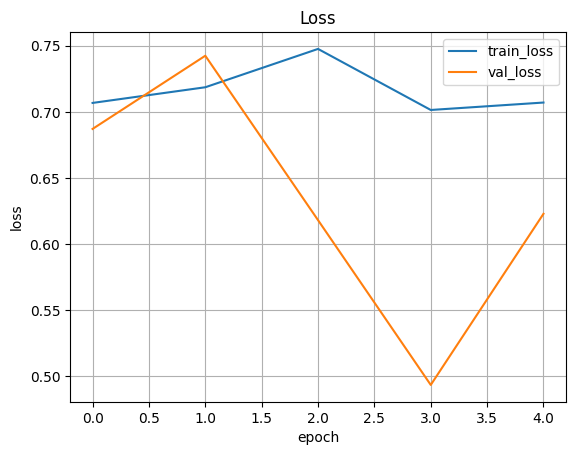

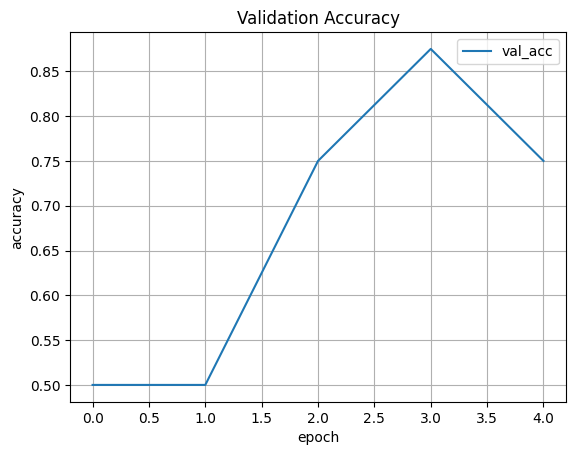

In [4]:
# Plot loss and val accuracy
# Run this in a fresh cell AFTER training
import matplotlib.pyplot as plt

assert 'history' in globals(), "history not defined — run the training cell first."

# Optional: quick sanity
for k in ["train_loss","val_loss","val_acc"]:
    assert k in history, f"history missing '{k}'"

# Loss curves
plt.figure()
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Loss")
plt.legend()
plt.grid(True)

# Validation accuracy
plt.figure()
plt.plot(history["val_acc"], label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

plt.show()


## 9) Evaluation — Load Pretrained Weights and Test
Point `weights_path` to your pretrained checkpoint (`.pth`) saved by this notebook **or your own weights**. We provide both **single‑image test** and **folder‑based batch test** with a confusion matrix.

In [5]:
from sklearn.metrics import classification_report, confusion_matrix

def _strip_prefix_if_present(state_dict, prefixes=("model.", "net.", "module.", "backbone.")):
    new_sd = {}
    for k, v in state_dict.items():
        new_key = k
        for p in prefixes:
            if new_key.startswith(p):
                new_key = new_key[len(p):]
        new_sd[new_key] = v
    return new_sd

def load_model_for_inference(weights_path: str, num_classes=2, class_names_override=None):
    model = models.densenet169(weights=models.DenseNet169_Weights.DEFAULT)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    ckpt = torch.load(weights_path, map_location="cpu")
    if isinstance(ckpt, dict) and "state_dict" in ckpt:
        state_dict = ckpt["state_dict"]
    elif isinstance(ckpt, dict) and "model_state" in ckpt:
        state_dict = ckpt["model_state"]
    else:
        state_dict = ckpt
    state_dict = _strip_prefix_if_present(state_dict)
    model.load_state_dict(state_dict, strict=False)
    model.eval().to(device)
    if isinstance(ckpt, dict):
        class_names = ckpt.get("class_names", class_names_override or ["Normal", "Abnormal"])
    else:
        class_names = class_names_override or ["Normal", "Abnormal"]
    return model, class_names

print("Inference loader ready.")

Inference loader ready.


### 9.a) Example: load weights

In [11]:
# ===================== Setup: Download Pretrained Weights =====================
import os, subprocess, sys, shlex

# Your public Drive file:
# https://drive.google.com/file/d/1rbIvyGzqdrlCC495L5oqSNPiRL-Q33EQ/view?usp=drive_link
WEIGHTS_ID   = "1rbIvyGzqdrlCC495L5oqSNPiRL-Q33EQ"
WEIGHTS_URL  = f"https://drive.google.com/uc?id={WEIGHTS_ID}"
WEIGHTS_PATH = os.path.join("checkpoints", "workshop_model.ckpt")

def _have_file_ok(path):
    return os.path.exists(path) and os.path.getsize(path) > 0

if not _have_file_ok(WEIGHTS_PATH):
    os.makedirs(os.path.dirname(WEIGHTS_PATH), exist_ok=True)
    print("Attempting to download pretrained weights from Google Drive...")

    ok = False

    # ---- Try gdown (preferred) ----
    try:
        subprocess.run([sys.executable, "-m", "pip", "install", "-q", "-U", "gdown>=5.2.0"], check=True)
        # gdown CLI
        subprocess.run(["gdown", WEIGHTS_URL, "-O", WEIGHTS_PATH, "--fuzzy"], check=True)
        ok = _have_file_ok(WEIGHTS_PATH)
    except subprocess.CalledProcessError as e:
        print(f"gdown failed: {e}")

    # ---- Fallback: wget with confirm token handling ----
    if not ok:
        print("Trying wget fallback...")
        cookies = "/tmp/gdown_cookies.txt"
        try:
            # First request to retrieve the confirm token
            cmd1 = f'wget --quiet --save-cookies {shlex.quote(cookies)} --keep-session-cookies --no-check-certificate "{WEIGHTS_URL}" -O-'
            cmd2 = r"sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' | head -n 1"
            token = subprocess.check_output(f"{cmd1} | {cmd2}", shell=True, text=True).strip()
            if token:
                dl_url = f"https://drive.google.com/uc?export=download&confirm={token}&id={WEIGHTS_ID}"
                subprocess.run(f'wget --load-cookies {shlex.quote(cookies)} "{dl_url}" -O {shlex.quote(WEIGHTS_PATH)} -q --no-check-certificate',
                               shell=True, check=False)
            ok = _have_file_ok(WEIGHTS_PATH)
        except subprocess.CalledProcessError as e:
            print(f"wget fallback failed: {e}")
        finally:
            try:
                os.remove(cookies)
            except OSError:
                pass

    if ok:
        print(f"✓ Weights downloaded successfully to {WEIGHTS_PATH}")
    else:
        print("⚠️ Could not download weights from Google Drive.")
        print("   Ensure the file is shared as: Anyone with the link (Viewer).")
        print("   If on a restricted Workspace, public downloads may be blocked.")
else:
    print(f"✓ Weights already exist at {WEIGHTS_PATH}")

print("\nSetup complete! Ready to run evaluation.")
# ===============================================================================


Attempting to download pretrained weights from Google Drive...
✓ Weights downloaded successfully to checkpoints/workshop_model.ckpt

Setup complete! Ready to run evaluation.


### 9.b) Single‑image prediction

In [ ]:
# Set an example image
# img_path = "/content/data/val/Normal/example_001.png"
# result = predict_single_image(img_path, model_inf, class_names_inf)
# print(result)

### 9.c) Batch evaluation on a folder (e.g., your validation set)

In [ ]:
# data_root = "/content/data/val"
# cm, report, classes = evaluate_folder(data_root, model_inf, val_tfms)
# print("Classes:", classes)
# print("Classification report:\n", report)

# # Plot confusion matrix (no seaborn, simple matplotlib)
# import itertools
# plt.figure()
# plt.imshow(cm, interpolation='nearest')
# plt.title("Confusion Matrix")
# plt.colorbar()
# tick_marks = np.arange(len(classes))
# plt.xticks(tick_marks, classes, rotation=45)
# plt.yticks(tick_marks, classes)

# thresh = cm.max() / 2.
# for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], 'd'),
#              horizontalalignment="center",
#              color="white" if cm[i, j] > thresh else "black")

# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.tight_layout()
# plt.show()

## 10) Notes
- Image size kept at **800×800** to match your code.
- Normalization kept at **mean=0.2636**, **std=0.1562** (replicated across 3 channels under the hood).
- Random H/V flips used in training, none in validation — consistent with your approach.
- You can easily swap the dataset paths or use Drive.
- For a quick run, keep 10 epochs; adjust later as needed.
- If your labels are reversed (0/1 mapping), just read `class_names` from `train_ds.classes` and interpret accordingly.
- The evaluation helpers mimic your testing flow: softmax probs, per‑image prediction, and a batch confusion matrix.

In [ ]:
# === Fetch PRETRAINED weights from Google Drive (only this file) ===
# Requires link access set to 'Anyone with the link' in Google Drive.
try:
    import gdown  # type: ignore
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", "gdown"])
    import gdown  # type: ignore

import os
os.makedirs(cfg.save_dir, exist_ok=True)

drive_file_id = "1HoiZ0waLFLc4Yse9-ITS0sKOhC8KhT3n"
dest_path = os.path.join(cfg.save_dir, cfg.ckpt_name)

if not os.path.exists(dest_path):
    url = f"https://drive.google.com/uc?id={drive_file_id}"
    print("Downloading pretrained weights to:", dest_path)
    gdown.download(url, dest_path, quiet=False)
else:
    print("Pretrained weights already present at:", dest_path)

In [ ]:
# === Evaluate PRETRAINED weights on TEST ===
weights_path = os.path.join(cfg.save_dir, cfg.ckpt_name)
model_inf, class_names_inf = load_model_for_inference(weights_path, num_classes=len(class_names))

y_true, y_pred = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model_inf(images)
        preds = logits.argmax(dim=1).cpu().numpy().tolist()
        y_pred.extend(preds)
        y_true.extend(labels.numpy().tolist())

print("Classes:", class_names_inf)
print(classification_report(y_true, y_pred, target_names=test_ds.classes, digits=4))